- 人工NNの基礎
- MNIST
- NNの実装

ニューラルネットワークの歴史は1940年代初めに遡る  
  
最小単位ブロックとして，ニューロンを使用する  
ニューロンは層を形成し，互いに接続されてネットワークを結ぶ  
信号が十分に強い時，ニューロンが活性化するといい，値を出力  
入力データが出力層に到達するまで伝搬され，予測を得る  
その予測を期待される出力と比較して誤差を計算し，ネットワークを改善  

ここではMNISTの学習をやってみる  
付録AではPythonによる線形代数(ベクトルテンソルの計算)と微分について  
付録Bでは誤差逆伝搬法について簡単に説明している  
付録Bでは一応式を追う理論的な説明が行われているが，お察しの直訳なのでなんだか雑．ここを詳しく知りたいならもっといい資料がある．

### 手書き数字のMNISTデータセット
[ソースコードとpkl](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/tree/master/code/dlgo/nn)  
2次元画像，サイズは784=28\*28，0は白，1は黒  
らしいんだけどこいつは0～255だったのでload時に正規化しとく

### MNISTデータの前処理
0~9のラベルをone-hotエンコーディングする    

In [29]:
import pickle, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
def encode_label(j):
    """ 0~9のラベルのone-hotエンコーディングを返す """
    e = np.zeros((10, 1))
    e[j] = 1
    return e

def shape_data(data, encode=True):
    """ flatten画像データとラベルのペアをzipで返す """
    features = [np.reshape(x, (784, 1)) / 255 for x in data[0]]
    labels = [encode_label(y) for y in data[1]]
    return zip(features, labels)

def load_data():
    data = np.load("../datasets/mnist/mnist.npz")
    train = shape_data((data['x_train'], data['y_train']))
    test = shape_data((data['x_test'], data['y_test']))
    return np.array(list(train)), np.array(list(test))

In [64]:
train, test = load_data()

この数字を画像から読み取るような問題は，説明できるより多くのことを知っているポラニーのパラドックスという現象で説明され，解決法を明示的に機械に示すのは難しい．

ここはまず，8とラベル付けされたデータ全てで，画素の位置ごとに平均を取ってみる  

In [65]:
def average_digit(data, digit):
    filtered_data = [x[0] for x in data if np.argmax(x[1]) == digit]
    filtered_array = np.asarray(filtered_data)
    return np.average(filtered_array, axis=0)

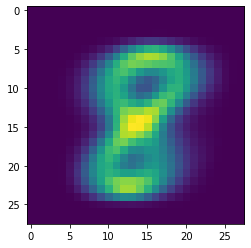

In [66]:
avg_eight = average_digit(train, 8)
img = np.reshape(avg_eight, (28, 28))
plt.imshow(img)
plt.show()

画素ごとの平均でも，8に関してはけっこうしっかり8っぽく見える  
ドット積による類似度計算で，他の画像がどれだけ平均に近いかを見てみる

In [67]:
W = np.transpose(avg_eight)
print(W @ train[2][0]) # ラベルは4
print(W @ train[17][0]) # ラベルは8

[[20.094909]]
[[54.5321651]]


数値が大きいほど被っているところが大きいということ  
なので，正解のラベルの方が数値が大きくなるのが自然

ドット積の出力を0~1の範囲に変換して扱いたい  
そこでシグモイド関数を用いる  
$$ \sigma (x) = \frac{1}{1 + e^{-x}} $$

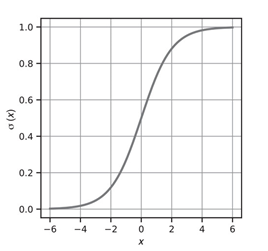

In [69]:
def sigmoid_double(x):
    return 1. / (1. + np.exp(-x))

def sigmoid(z):
    """ ベクトルに対するシグモイド関数の実装 """
    return np.vectorize(sigmoid_double)(z)

このままさっきの値をシグモイドに入れても，同じくらいの出力になってしまう  
そこで，適切なバイアス項を加えることでしっかり区別できるようになる

In [70]:
def predict(x, W, b):
    return sigmoid_double(W @ x + b)

b = -45
print(predict(train[2][0], W, b))
print(predict(train[17][0], W, b))

[[1.52706108e-11]]
[[0.99992752]]


これより，4に対しては限りなく0，8に対しては限りなく1に近い出力を得られ，区別ができた  
このように，入力ベクトルを$\sigma(Wx+b)$に写像する手順をロジスティック回帰と呼ぶ  
入力サイズが4の時の例を以下に示す

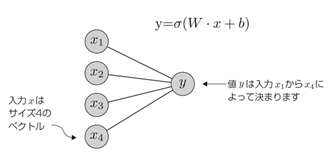